In [7]:
# Importing essentials libraries

from keras.layers import *
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report

import numpy as np
import pandas as pd
import os
import cv2

In [9]:
# Intialization of model
model = Sequential()

# Adding layer 1
model.add(Conv2D(filters=100,padding='same',activation='relu',kernel_size=(3,3),input_shape=(150, 150, 3)))
model.add(MaxPooling2D(padding='same'))

# Adding layer 2
model.add(Conv2D(filters=100,padding='same',activation='relu',kernel_size=(3,3)))
model.add(MaxPooling2D(padding='same'))

# Flattening of data
model.add(Flatten())

# Adding dense layer 1
model.add(Dropout(0.5))
model.add(Dense(units=50,activation='relu'))

# Adding output layer
model.add(Dense(units=2,activation='softmax'))

# Compiling model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 100)     2800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 100)       90100     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 144400)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 144400)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)              

In [12]:
# Intializing the Datagen
datagen=ImageDataGenerator(validation_split=0.2,rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Getting the classes
classes_name = os.listdir('./dataset/')

# Creating training data
train_generator = datagen.flow_from_directory('./dataset/',
                                              classes=classes_name,                                         
                                              subset='training',
                                              target_size=(150,150),
                                              batch_size=10)

# Creating validation data
val_generator = datagen.flow_from_directory('./dataset/',
                                            classes=classes_name,
                                            subset='validation',
                                            target_size=(150,150),
                                            batch_size=10)

Found 1101 images belonging to 2 classes.
Found 275 images belonging to 2 classes.


In [13]:
#history = model.fit_generator(train_generator,
 #                             epochs=30,
  #                            validation_data=val_generator,
   #                           verbose=True)

Epoch 1/30
111/111 [==============================] - 53s 475ms/step - loss: 0.6854 - accuracy: 0.5086 - val_loss: 0.6511 - val_accuracy: 0.7418
Epoch 2/30
111/111 [==============================] - 59s 528ms/step - loss: 0.4654 - accuracy: 0.8347 - val_loss: 0.6335 - val_accuracy: 0.8691
Epoch 3/30
111/111 [==============================] - 59s 532ms/step - loss: 0.2885 - accuracy: 0.9037 - val_loss: 0.2668 - val_accuracy: 0.9091
Epoch 4/30
111/111 [==============================] - 59s 536ms/step - loss: 0.2473 - accuracy: 0.9101 - val_loss: 0.2381 - val_accuracy: 0.9418
Epoch 5/30
111/111 [==============================] - 58s 526ms/step - loss: 0.2244 - accuracy: 0.9210 - val_loss: 0.0614 - val_accuracy: 0.8800
Epoch 6/30
111/111 [==============================] - 59s 531ms/step - loss: 0.2649 - accuracy: 0.9019 - val_loss: 0.2197 - val_accuracy: 0.9455
Epoch 7/30
111/111 [==============================] - 59s 531ms/step - loss: 0.1938 - accuracy: 0.9346 - val_loss: 0.1147 - val_ac

In [20]:
#face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#model.save('Face_mask.h5')
model.load_weights('Face_mask.h5')

In [34]:
labels_dict={0:'without_mask',1:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(150,150))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        #print(result)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()

In [29]:
def preprocessing(img):
    img = cv2.resize(img, (150, 150)) # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img/255                                   # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    img = np.expand_dims(img, axis=0)
    return img

No Mask


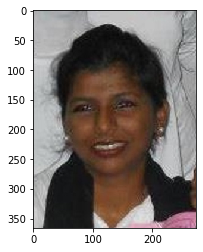

In [28]:
img = cv2.imread('./dataset/without_mask/10.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
plt.imshow(img)
im = preprocessing(img)
p = model.predict(im)
if p[0][0] > p[0][1]:
    print('No Mask')
else:
    print('Mask')

array([[0.0194939 , 0.98050606]], dtype=float32)